In [1]:
import time
import math
import cv2
import os
from skimage import io
from skimage.color import rgb2gray

import numpy as np

import os.path
import matplotlib.pyplot as plt

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.distributions import Normal, Categorical

IMG_DIR="/tmp/capture_20180813_1912"
SIM_IMG_DIR="/tmp/capture_20180809_1039"

In [2]:
class CaptureDataset(Dataset):
    """Capture dataset."""

    def __init__(self, root_dir):
        """
        Args:
            root_dir (string): Directory with all the images.
        """
        self.root_dir = root_dir
        self.img_names = []
        listing = os.listdir(root_dir)
        for files in listing:
            if files.endswith('.jpeg'):
                self.img_names.append(files[:len(files)-len('.jpeg')])
        self.img_names.sort(key=int)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.img_names[idx] + '.jpeg')
        image = rgb2gray(io.imread(img_name))
        print(img_name)
        sample = {'image': image}
        return sample

In [3]:
dataset = CaptureDataset(IMG_DIR)
sim_dataset = CaptureDataset(SIM_IMG_DIR)

In [4]:
def apply_warp_filter(img):

#     print("applying filter to img:", img)
#     print("applying filter to img:", img.shape)
    warp_img = img[50:]

    pts1 = np.float32([
        [13, 33], [54, 8], [147, 33], [107, 8]
    ])
    pts2 = np.float32([
        [60, 80], [60, 20], [120, 80], [120, 20]
    ])
    M = cv2.getPerspectiveTransform(pts1, pts2)
    
    x = 0.01
    h_base = np.array([
        -x, -x, -x, -x, 2*x, 2*x, 2*x, 2*x, -x, -x, -x, -x,
    ])
    arrays = [h_base for _ in range(12)]
    h_kernel = np.stack(arrays, axis=0)

    v_kernel = h_kernel.T
    
    d1_kernel = [
        [2*x,2*x, -x, -x, -x, -x, -x, -x, -x,  0,  0,  0],
        [2*x,2*x,2*x, -x, -x, -x, -x, -x, -x, -x,  0,  0],
        [2*x,2*x,2*x,2*x, -x, -x, -x, -x, -x, -x, -x,  0],
        [ -x,2*x,2*x,2*x,2*x, -x, -x, -x, -x, -x, -x, -x],
        [ -x, -x,2*x,2*x,2*x,2*x, -x, -x, -x, -x, -x, -x],
        [ -x, -x, -x,2*x,2*x,2*x,2*x, -x, -x, -x, -x, -x],
        [ -x, -x, -x, -x,2*x,2*x,2*x,2*x, -x, -x, -x, -x],
        [ -x, -x, -x, -x, -x,2*x,2*x,2*x,2*x, -x, -x, -x],
        [ -x, -x, -x, -x, -x, -x,2*x,2*x,2*x,2*x, -x, -x],
        [  0, -x, -x, -x, -x, -x, -x,2*x,2*x,2*x,2*x, -x],
        [  0,  0, -x, -x, -x, -x, -x, -x,2*x,2*x,2*x,2*x],
        [  0,  0,  0, -x, -x, -x, -x, -x, -x,2*x,2*x,2*x]
    ]

    d2_kernel = np.fliplr(d1_kernel)
    average_kernel = (h_kernel + v_kernel + d1_kernel + d2_kernel)
    
    warp_img = cv2.warpPerspective(
            warp_img, M, (160,90),
        )
    
    img = cv2.filter2D(
        warp_img,
        -1,
        average_kernel,
    )
    
    img = np.divide( np.subtract(
                             img, 
                            np.min(img)
                        ), 
                       np.subtract(
                          np.max(img), 
                          np.min(img)
                       )
                    )
    img = (img > np.average(img) + 0.05 ) * 255.0
    print(np.average(img))
    # Clamping is what gives us the very contrasted lines.
#     processed = np.clip(processed, 0, 255)    
#     print(np.average(processed))
    
    plt.subplot(121),plt.imshow(warp_img),plt.title('Input')
    plt.subplot(122),plt.imshow(img),plt.title('Output')

    plt.show()
    
    return img

/tmp/capture_20180813_1912/1.jpeg
24.667708333333334


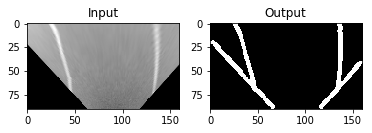

/tmp/capture_20180809_1039/1.jpeg
20.577083333333334


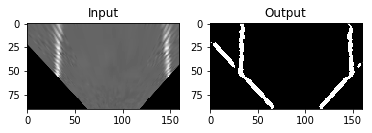

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
img_data = dataset[1]["image"]
plt.set_cmap('gray')
apply_warp_filter(img_data)

sim_img_data = sim_dataset[1]["image"]
apply_warp_filter(sim_img_data)

/tmp/capture_20180813_1912/0.jpeg
/tmp/capture_20180813_1912/0.jpeg
24.667708333333334


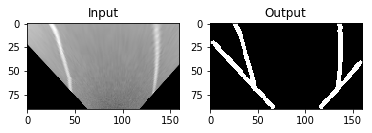

/tmp/capture_20180813_1912/1.jpeg
/tmp/capture_20180813_1912/1.jpeg
24.667708333333334


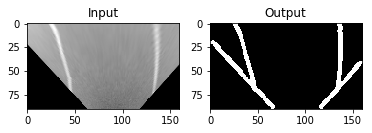

/tmp/capture_20180813_1912/2.jpeg
/tmp/capture_20180813_1912/2.jpeg
24.667708333333334


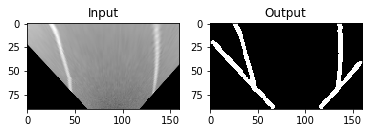

/tmp/capture_20180813_1912/3.jpeg
/tmp/capture_20180813_1912/3.jpeg
24.632291666666667


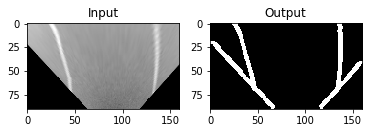

/tmp/capture_20180813_1912/4.jpeg
/tmp/capture_20180813_1912/4.jpeg
24.561458333333334


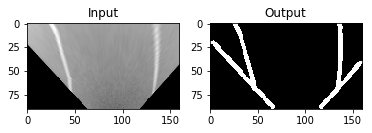

/tmp/capture_20180813_1912/5.jpeg
/tmp/capture_20180813_1912/5.jpeg
24.65


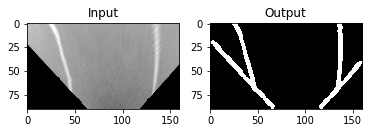

/tmp/capture_20180813_1912/6.jpeg
/tmp/capture_20180813_1912/6.jpeg
24.455208333333335


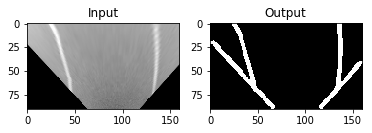

/tmp/capture_20180813_1912/7.jpeg
/tmp/capture_20180813_1912/7.jpeg
24.33125


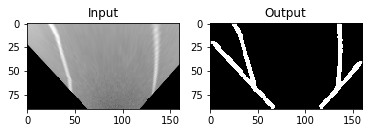

/tmp/capture_20180813_1912/8.jpeg
/tmp/capture_20180813_1912/8.jpeg
24.419791666666665


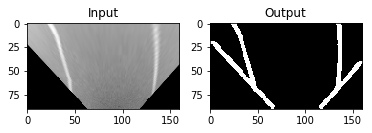

/tmp/capture_20180813_1912/9.jpeg
/tmp/capture_20180813_1912/9.jpeg
24.685416666666665


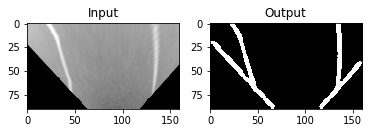

/tmp/capture_20180813_1912/10.jpeg
/tmp/capture_20180813_1912/10.jpeg
24.579166666666666


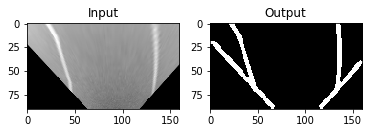

/tmp/capture_20180813_1912/11.jpeg
/tmp/capture_20180813_1912/11.jpeg
24.738541666666666


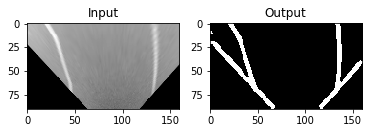

/tmp/capture_20180813_1912/12.jpeg
/tmp/capture_20180813_1912/12.jpeg
24.596875


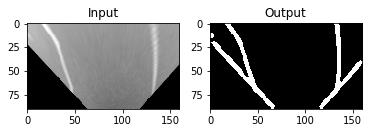

/tmp/capture_20180813_1912/13.jpeg
/tmp/capture_20180813_1912/13.jpeg
24.880208333333332


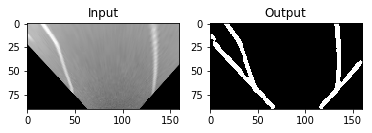

/tmp/capture_20180813_1912/14.jpeg
/tmp/capture_20180813_1912/14.jpeg
25.128125


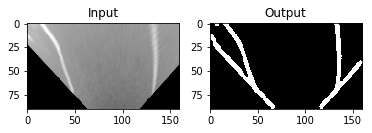

/tmp/capture_20180813_1912/15.jpeg
/tmp/capture_20180813_1912/15.jpeg
25.553125


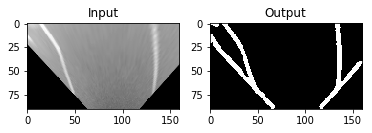

/tmp/capture_20180813_1912/16.jpeg
/tmp/capture_20180813_1912/16.jpeg
25.5


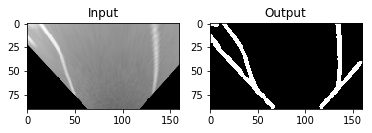

/tmp/capture_20180813_1912/17.jpeg
/tmp/capture_20180813_1912/17.jpeg
25.517708333333335


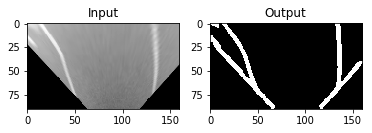

/tmp/capture_20180813_1912/18.jpeg
/tmp/capture_20180813_1912/18.jpeg
25.2875


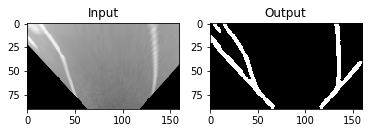

/tmp/capture_20180813_1912/19.jpeg
/tmp/capture_20180813_1912/19.jpeg
25.641666666666666


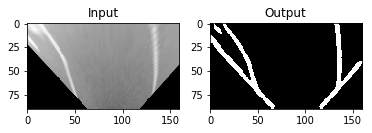

/tmp/capture_20180813_1912/20.jpeg
/tmp/capture_20180813_1912/20.jpeg
25.570833333333333


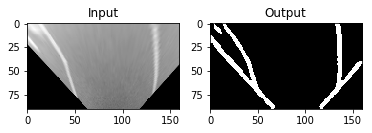

/tmp/capture_20180813_1912/21.jpeg
/tmp/capture_20180813_1912/21.jpeg
25.747916666666665


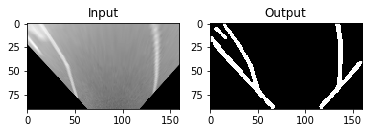

/tmp/capture_20180813_1912/22.jpeg
/tmp/capture_20180813_1912/22.jpeg
25.429166666666667


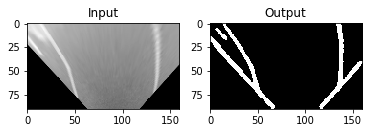

/tmp/capture_20180813_1912/23.jpeg
/tmp/capture_20180813_1912/23.jpeg
25.004166666666666


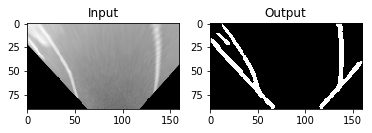

/tmp/capture_20180813_1912/24.jpeg
/tmp/capture_20180813_1912/24.jpeg
24.207291666666666


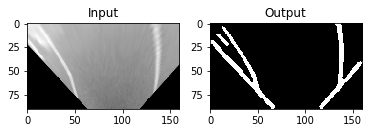

/tmp/capture_20180813_1912/25.jpeg
/tmp/capture_20180813_1912/25.jpeg
24.083333333333332


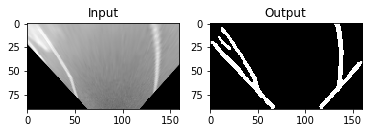

/tmp/capture_20180813_1912/26.jpeg
/tmp/capture_20180813_1912/26.jpeg
24.933333333333334


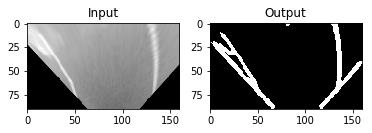

/tmp/capture_20180813_1912/27.jpeg
/tmp/capture_20180813_1912/27.jpeg
25.340625


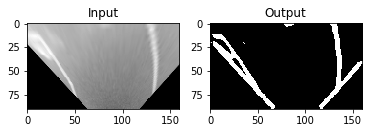

/tmp/capture_20180813_1912/28.jpeg
/tmp/capture_20180813_1912/28.jpeg
25.057291666666668


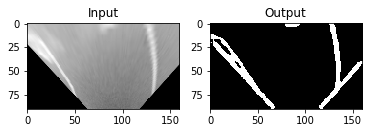

/tmp/capture_20180813_1912/29.jpeg
/tmp/capture_20180813_1912/29.jpeg
23.357291666666665


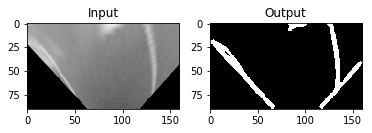

/tmp/capture_20180813_1912/30.jpeg
/tmp/capture_20180813_1912/30.jpeg
24.189583333333335


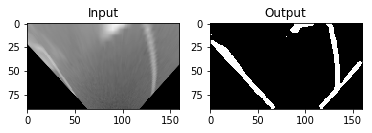

/tmp/capture_20180813_1912/31.jpeg
/tmp/capture_20180813_1912/31.jpeg
24.791666666666668


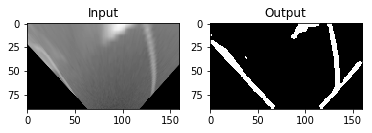

/tmp/capture_20180813_1912/32.jpeg
/tmp/capture_20180813_1912/32.jpeg
26.190625


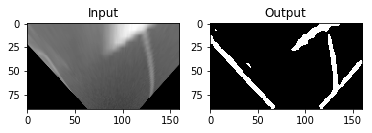

/tmp/capture_20180813_1912/33.jpeg
/tmp/capture_20180813_1912/33.jpeg
26.934375


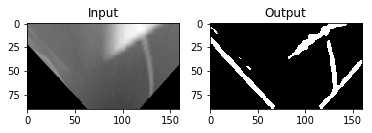

/tmp/capture_20180813_1912/34.jpeg
/tmp/capture_20180813_1912/34.jpeg
27.394791666666666


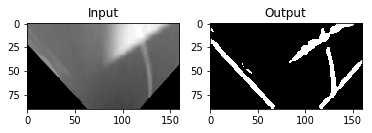

/tmp/capture_20180813_1912/35.jpeg
/tmp/capture_20180813_1912/35.jpeg
31.255208333333332


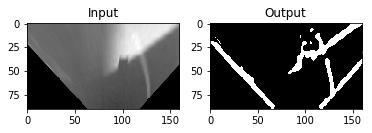

/tmp/capture_20180813_1912/36.jpeg
/tmp/capture_20180813_1912/36.jpeg
32.034375


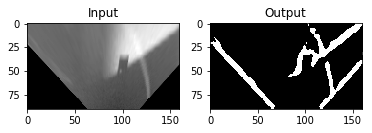

/tmp/capture_20180813_1912/37.jpeg
/tmp/capture_20180813_1912/37.jpeg
30.847916666666666


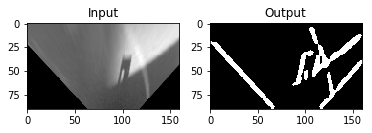

/tmp/capture_20180813_1912/38.jpeg
/tmp/capture_20180813_1912/38.jpeg
32.016666666666666


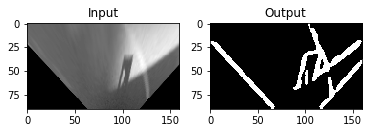

/tmp/capture_20180813_1912/39.jpeg
/tmp/capture_20180813_1912/39.jpeg
30.759375


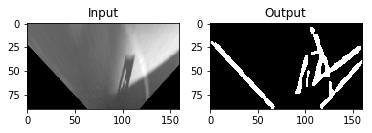

/tmp/capture_20180813_1912/40.jpeg
/tmp/capture_20180813_1912/40.jpeg
28.36875


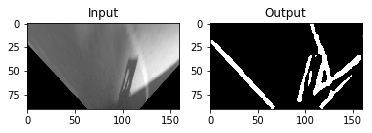

/tmp/capture_20180813_1912/41.jpeg
/tmp/capture_20180813_1912/41.jpeg
24.189583333333335


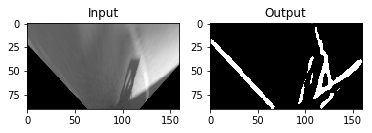

/tmp/capture_20180813_1912/42.jpeg
/tmp/capture_20180813_1912/42.jpeg
20.860416666666666


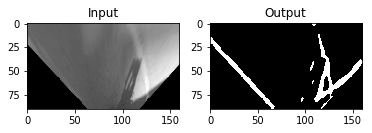

/tmp/capture_20180813_1912/43.jpeg
/tmp/capture_20180813_1912/43.jpeg
20.594791666666666


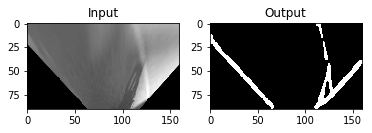

/tmp/capture_20180813_1912/44.jpeg
/tmp/capture_20180813_1912/44.jpeg
20.825


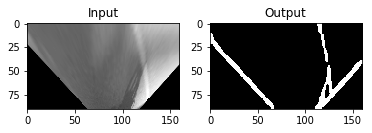

/tmp/capture_20180813_1912/45.jpeg
/tmp/capture_20180813_1912/45.jpeg
20.08125


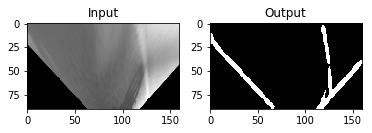

/tmp/capture_20180813_1912/46.jpeg
/tmp/capture_20180813_1912/46.jpeg
19.744791666666668


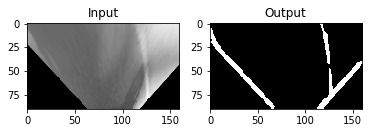

/tmp/capture_20180813_1912/47.jpeg
/tmp/capture_20180813_1912/47.jpeg
19.815625


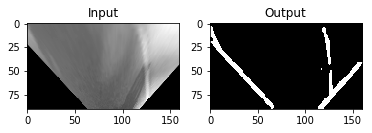

/tmp/capture_20180813_1912/48.jpeg
/tmp/capture_20180813_1912/48.jpeg
19.125


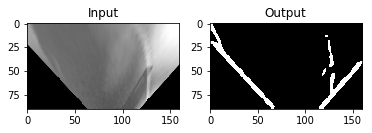

/tmp/capture_20180813_1912/49.jpeg
/tmp/capture_20180813_1912/49.jpeg
18.522916666666667


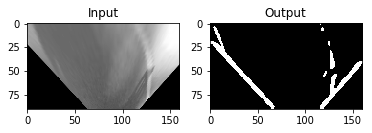

/tmp/capture_20180813_1912/50.jpeg
/tmp/capture_20180813_1912/50.jpeg
18.522916666666667


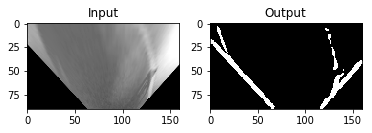

/tmp/capture_20180813_1912/51.jpeg
/tmp/capture_20180813_1912/51.jpeg
18.416666666666668


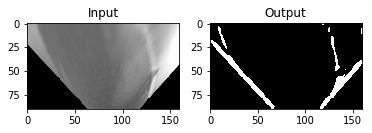

/tmp/capture_20180813_1912/52.jpeg
/tmp/capture_20180813_1912/52.jpeg
18.151041666666668


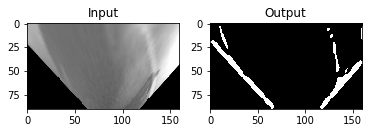

/tmp/capture_20180813_1912/53.jpeg
/tmp/capture_20180813_1912/53.jpeg
18.753125


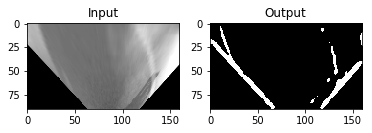

/tmp/capture_20180813_1912/54.jpeg
/tmp/capture_20180813_1912/54.jpeg
19.992708333333333


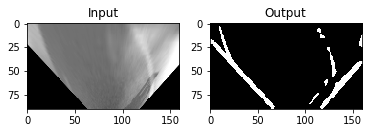

/tmp/capture_20180813_1912/55.jpeg
/tmp/capture_20180813_1912/55.jpeg
21.710416666666667


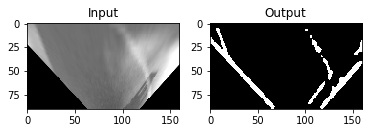

/tmp/capture_20180813_1912/56.jpeg
/tmp/capture_20180813_1912/56.jpeg
22.188541666666666


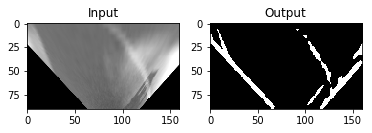

/tmp/capture_20180813_1912/57.jpeg
/tmp/capture_20180813_1912/57.jpeg
21.834375


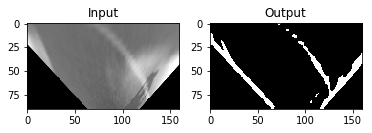

/tmp/capture_20180813_1912/58.jpeg
/tmp/capture_20180813_1912/58.jpeg
22.241666666666667


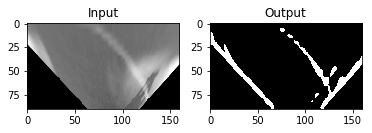

/tmp/capture_20180813_1912/59.jpeg
/tmp/capture_20180813_1912/59.jpeg
23.870833333333334


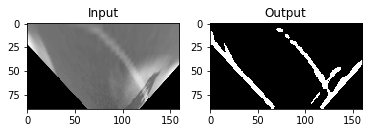

/tmp/capture_20180813_1912/60.jpeg
/tmp/capture_20180813_1912/60.jpeg
24.136458333333334


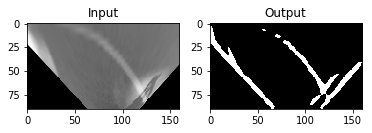

/tmp/capture_20180813_1912/61.jpeg
/tmp/capture_20180813_1912/61.jpeg
23.091666666666665


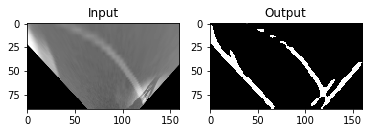

/tmp/capture_20180813_1912/62.jpeg
/tmp/capture_20180813_1912/62.jpeg
22.365625


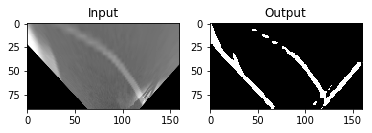

/tmp/capture_20180813_1912/63.jpeg
/tmp/capture_20180813_1912/63.jpeg
23.782291666666666


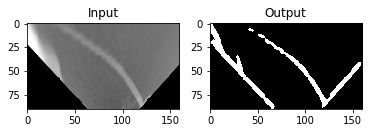

/tmp/capture_20180813_1912/64.jpeg
/tmp/capture_20180813_1912/64.jpeg
24.526041666666668


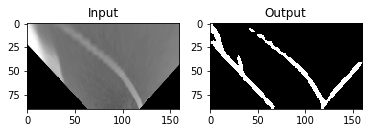

/tmp/capture_20180813_1912/65.jpeg
/tmp/capture_20180813_1912/65.jpeg
25.446875


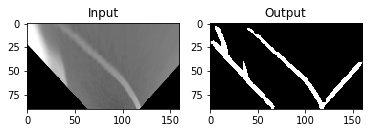

/tmp/capture_20180813_1912/66.jpeg
/tmp/capture_20180813_1912/66.jpeg
25.960416666666667


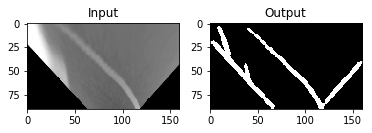

/tmp/capture_20180813_1912/67.jpeg
/tmp/capture_20180813_1912/67.jpeg
25.81875


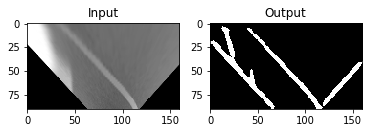

/tmp/capture_20180813_1912/68.jpeg
/tmp/capture_20180813_1912/68.jpeg
25.358333333333334


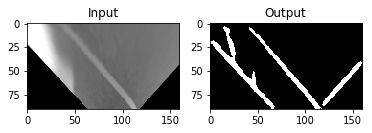

/tmp/capture_20180813_1912/69.jpeg
/tmp/capture_20180813_1912/69.jpeg
24.260416666666668


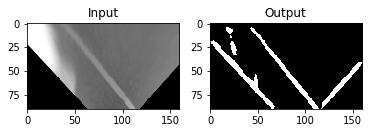

/tmp/capture_20180813_1912/70.jpeg
/tmp/capture_20180813_1912/70.jpeg
25.092708333333334


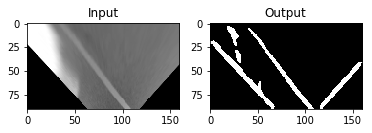

/tmp/capture_20180813_1912/71.jpeg
/tmp/capture_20180813_1912/71.jpeg
26.03125


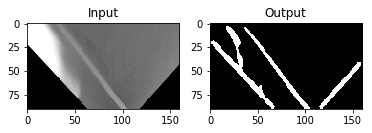

/tmp/capture_20180813_1912/72.jpeg
/tmp/capture_20180813_1912/72.jpeg
26.403125


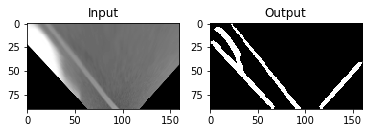

/tmp/capture_20180813_1912/73.jpeg
/tmp/capture_20180813_1912/73.jpeg
25.7125


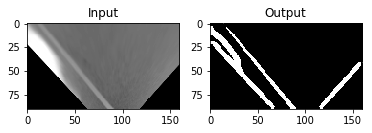

/tmp/capture_20180813_1912/74.jpeg
/tmp/capture_20180813_1912/74.jpeg
23.215625


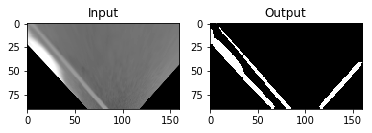

/tmp/capture_20180813_1912/75.jpeg
/tmp/capture_20180813_1912/75.jpeg
19.390625


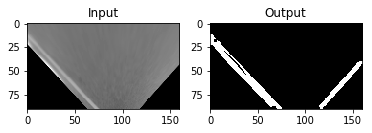

/tmp/capture_20180813_1912/76.jpeg
/tmp/capture_20180813_1912/76.jpeg
14.644791666666666


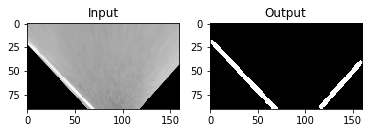

/tmp/capture_20180813_1912/77.jpeg
/tmp/capture_20180813_1912/77.jpeg
14.078125


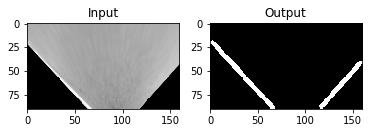

/tmp/capture_20180813_1912/78.jpeg
/tmp/capture_20180813_1912/78.jpeg
14.821875


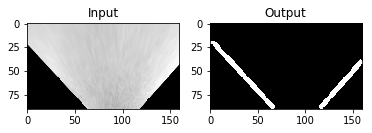

/tmp/capture_20180813_1912/79.jpeg
/tmp/capture_20180813_1912/79.jpeg
14.786458333333334


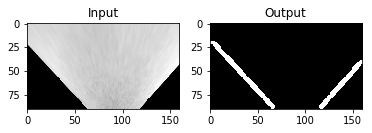

/tmp/capture_20180813_1912/80.jpeg
/tmp/capture_20180813_1912/80.jpeg
14.644791666666666


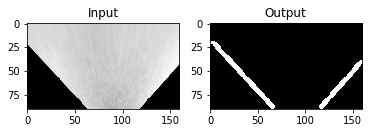

/tmp/capture_20180813_1912/81.jpeg
/tmp/capture_20180813_1912/81.jpeg
14.680208333333333


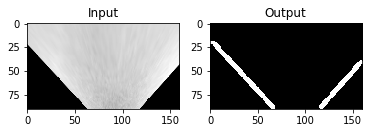

/tmp/capture_20180813_1912/82.jpeg
/tmp/capture_20180813_1912/82.jpeg
14.6625


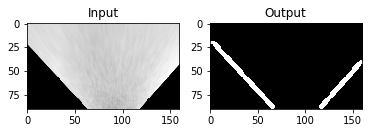

/tmp/capture_20180813_1912/83.jpeg
/tmp/capture_20180813_1912/83.jpeg
14.821875


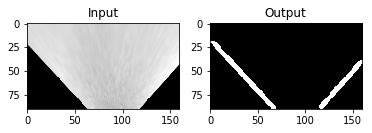

/tmp/capture_20180813_1912/84.jpeg
/tmp/capture_20180813_1912/84.jpeg
14.786458333333334


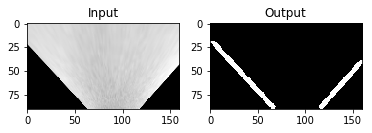

/tmp/capture_20180813_1912/85.jpeg
/tmp/capture_20180813_1912/85.jpeg
14.680208333333333


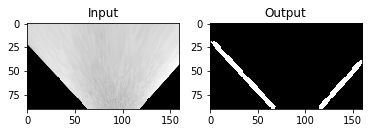

/tmp/capture_20180813_1912/86.jpeg
/tmp/capture_20180813_1912/86.jpeg
14.6625


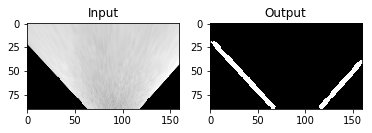

/tmp/capture_20180813_1912/87.jpeg
/tmp/capture_20180813_1912/87.jpeg
14.573958333333334


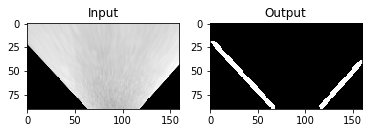

/tmp/capture_20180813_1912/88.jpeg
/tmp/capture_20180813_1912/88.jpeg
14.76875


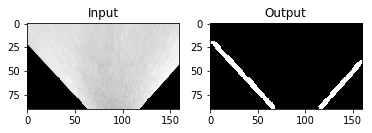

/tmp/capture_20180813_1912/89.jpeg
/tmp/capture_20180813_1912/89.jpeg
14.715625


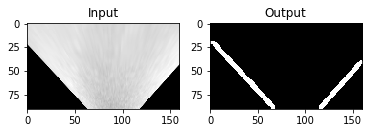

/tmp/capture_20180813_1912/90.jpeg
/tmp/capture_20180813_1912/90.jpeg
14.627083333333333


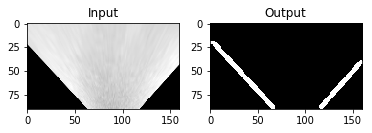

/tmp/capture_20180813_1912/91.jpeg
/tmp/capture_20180813_1912/91.jpeg
14.76875


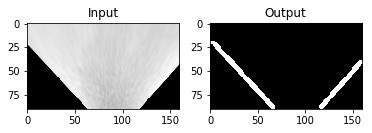

/tmp/capture_20180813_1912/92.jpeg
/tmp/capture_20180813_1912/92.jpeg
14.804166666666667


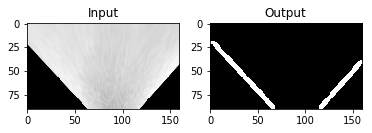

/tmp/capture_20180813_1912/93.jpeg
/tmp/capture_20180813_1912/93.jpeg
14.715625


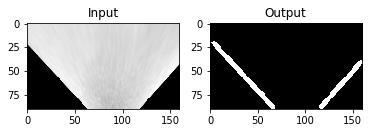

/tmp/capture_20180813_1912/94.jpeg
/tmp/capture_20180813_1912/94.jpeg
14.715625


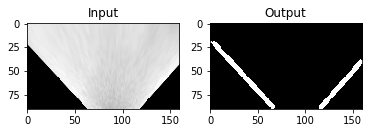

/tmp/capture_20180813_1912/95.jpeg
/tmp/capture_20180813_1912/95.jpeg
14.697916666666666


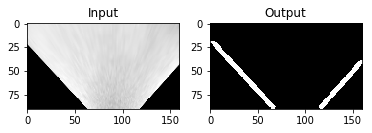

/tmp/capture_20180813_1912/96.jpeg
/tmp/capture_20180813_1912/96.jpeg
16.026041666666668


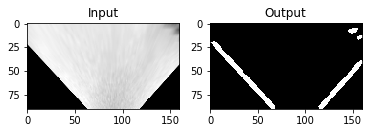

/tmp/capture_20180813_1912/97.jpeg
/tmp/capture_20180813_1912/97.jpeg
17.885416666666668


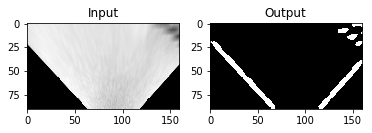

/tmp/capture_20180813_1912/98.jpeg
/tmp/capture_20180813_1912/98.jpeg
19.603125


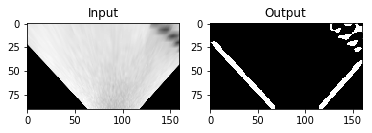

/tmp/capture_20180813_1912/99.jpeg
/tmp/capture_20180813_1912/99.jpeg
20.08125


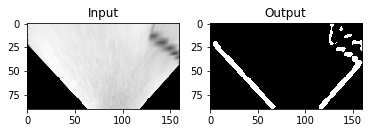

/tmp/capture_20180813_1912/100.jpeg
/tmp/capture_20180813_1912/100.jpeg
20.913541666666667


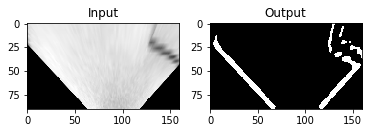

/tmp/capture_20180813_1912/101.jpeg
/tmp/capture_20180813_1912/101.jpeg
22.383333333333333


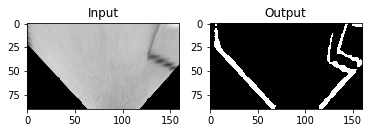

/tmp/capture_20180813_1912/102.jpeg
/tmp/capture_20180813_1912/102.jpeg
22.011458333333334


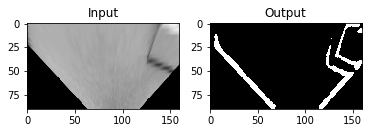

/tmp/capture_20180813_1912/103.jpeg
/tmp/capture_20180813_1912/103.jpeg
23.410416666666666


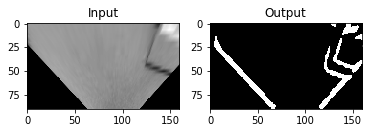

/tmp/capture_20180813_1912/104.jpeg
/tmp/capture_20180813_1912/104.jpeg
27.625


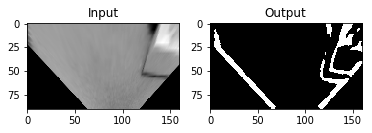

/tmp/capture_20180813_1912/105.jpeg
/tmp/capture_20180813_1912/105.jpeg
28.421875


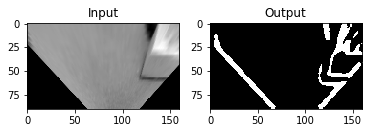

/tmp/capture_20180813_1912/106.jpeg
/tmp/capture_20180813_1912/106.jpeg
29.838541666666668


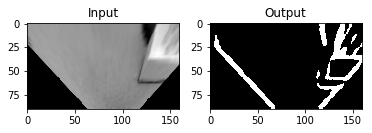

/tmp/capture_20180813_1912/107.jpeg
/tmp/capture_20180813_1912/107.jpeg
32.052083333333336


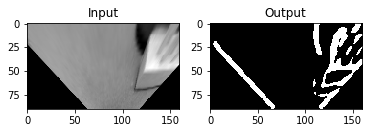

/tmp/capture_20180813_1912/108.jpeg
/tmp/capture_20180813_1912/108.jpeg
31.290625


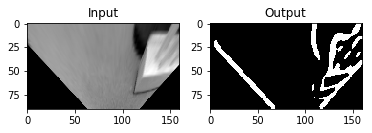

/tmp/capture_20180813_1912/109.jpeg
/tmp/capture_20180813_1912/109.jpeg
30.245833333333334


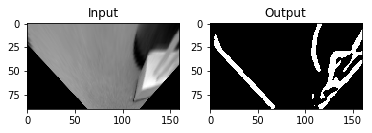

/tmp/capture_20180813_1912/110.jpeg
/tmp/capture_20180813_1912/110.jpeg
29.75


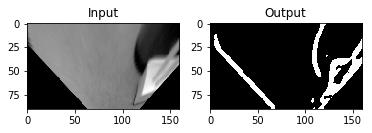

/tmp/capture_20180813_1912/111.jpeg
/tmp/capture_20180813_1912/111.jpeg
26.969791666666666


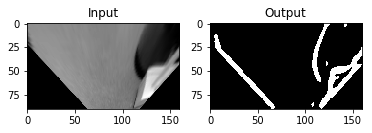

/tmp/capture_20180813_1912/112.jpeg
/tmp/capture_20180813_1912/112.jpeg
22.277083333333334


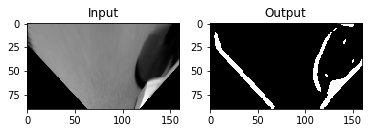

/tmp/capture_20180813_1912/113.jpeg
/tmp/capture_20180813_1912/113.jpeg
20.382291666666667


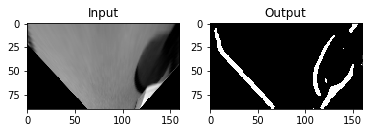

/tmp/capture_20180813_1912/114.jpeg
/tmp/capture_20180813_1912/114.jpeg
19.266666666666666


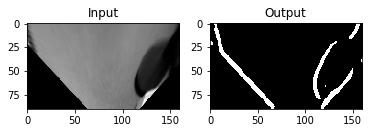

/tmp/capture_20180813_1912/115.jpeg
/tmp/capture_20180813_1912/115.jpeg
20.523958333333333


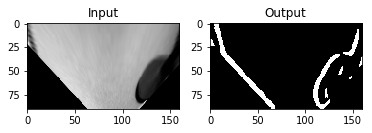

/tmp/capture_20180813_1912/116.jpeg
/tmp/capture_20180813_1912/116.jpeg
20.29375


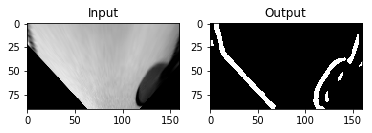

/tmp/capture_20180813_1912/117.jpeg
/tmp/capture_20180813_1912/117.jpeg
18.275


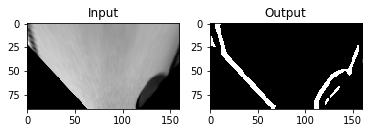

/tmp/capture_20180813_1912/118.jpeg
/tmp/capture_20180813_1912/118.jpeg
17.761458333333334


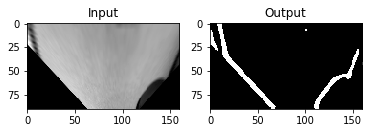

/tmp/capture_20180813_1912/119.jpeg
/tmp/capture_20180813_1912/119.jpeg
18.859375


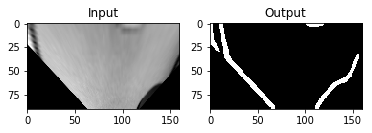

/tmp/capture_20180813_1912/120.jpeg
/tmp/capture_20180813_1912/120.jpeg
21.072916666666668


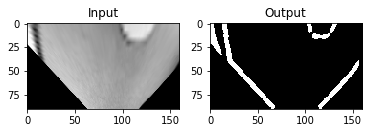

/tmp/capture_20180813_1912/121.jpeg
/tmp/capture_20180813_1912/121.jpeg
22.666666666666668


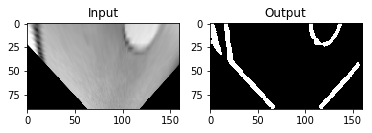

/tmp/capture_20180813_1912/122.jpeg
/tmp/capture_20180813_1912/122.jpeg
26.190625


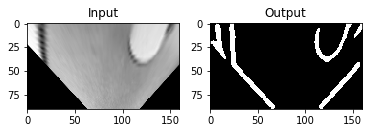

/tmp/capture_20180813_1912/123.jpeg
/tmp/capture_20180813_1912/123.jpeg
27.430208333333333


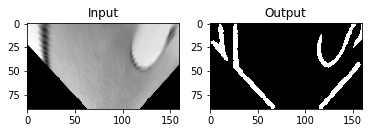

In [6]:
for i, data in enumerate(dataset, 0):
    img = dataset[i]["image"]
    apply_warp_filter(img)

In [16]:
class PPOPixelsCNN(nn.Module):
    def __init__(self):
        super(PPOPixelsCNN, self).__init__()
        self.hidden_size = 128
        self.fixed_action_std = 0
        self.cv1 = nn.Conv2d(1, 12, 5, stride=2)
        self.cv2 = nn.Conv2d(12, 16, 5, stride=3)
        self.dp1 = nn.Dropout(p=0.1)
        self.fc1 = nn.Linear(5200, self.hidden_size)
        self.gru = nn.GRUCell(self.hidden_size, self.hidden_size)
        self.fc1_a = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc2_a = nn.Linear(self.hidden_size, 2 * 2)
        self.fc1_v = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc2_v = nn.Linear(self.hidden_size, 1)

    def forward(self, inputs, hiddens, masks):
        x = F.elu(self.cv1(inputs))
        x = F.elu(self.cv2(x))
        x = self.dp1(x)

        x = x.view(-1, 5200)
        x = F.elu(self.fc1(x))

        if inputs.size(0) == hiddens.size(0):
            x = hiddens = self.gru(x, hiddens * masks)
        else:
            x = x.view(-1, hiddens.size(0), x.size(1))
            masks = masks.view(-1, hiddens.size(0), 1)
            outputs = []
            for i in range(x.size(0)):
                hx = hiddens = self.gru(x[i], hiddens * masks[i])
                outputs.append(hx)
            x = torch.cat(outputs, 0)
        x = F.tanh(x)

        # Action head.
        a = F.tanh(self.fc1_a(x))
        a = F.tanh(self.fc2_a(a))

        v = F.tanh(self.fc1_v(x))
        v = self.fc2_v(v)
        
        return v, a, hiddens
    
    def action(self, inputs, hiddens, masks, deterministic=False):
        value, x, hiddens = self(inputs, hiddens, masks)
        slices = torch.split(x, 2, 1)
        action_mean = slices[0]
        action_logstd = slices[1]
        action_std = action_logstd.exp()

        if self.fixed_action_std > 0.0:
            action_std = (
                self.fixed_action_std *
                torch.ones(action_mean.size()).float()
            ).to(device)
            action_logstd = action_std.log()

        m = Normal(action_mean, action_std)

        if deterministic is False:
            actions = m.sample()
        else:
            actions = action_mean

        # log_probs (sum on actions) -> batch x 1
        log_probs = m.log_prob(actions).sum(-1, keepdim=True)

        # entropy (sum on actions / mean on batch) -> 1x1
        entropy = 0.5 + 0.5 * math.log(2 * math.pi) + action_logstd
        entropy = entropy.sum(-1, keepdim=True)

        return value, actions, hiddens, log_probs, entropy

In [17]:
# load model
MODEL = "/Users/matthieurouif/Desktop/policy.pt"
device = torch.device("cpu")
policy = PPOPixelsCNN().to(device)
policy.load_state_dict(
    torch.load(MODEL, map_location='cpu'),
)

/tmp/capture_20180813_1703/2.jpeg
24.75625


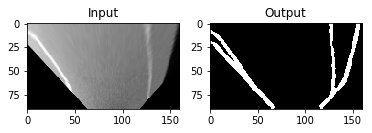

tensor([[-0.2745,  0.8662]])


In [18]:
policy.eval()
end = False

hiddens = torch.zeros(1, 128).to(device)
masks = torch.ones(1, 1).to(device)
img_data = dataset[2]["image"]
plt.set_cmap('gray')

observation = apply_warp_filter(img_data)
cameras = [observation / 127.5 - 1]
observation = np.concatenate(
    (
        np.stack(cameras),
    ),
    axis=-1,
)

observations = torch.from_numpy(observation).float().unsqueeze(0).to(device)
with torch.no_grad():
    while not end:
        value, action, hiddens, log_prob, entropy = policy.action(
                    observations.detach(),
                    hiddens.detach(),
                    masks.detach(),
                    deterministic=True,
                )
        print(action)
        end = True